# Install

In [1]:
!pip install catboost
!pip install optuna
!pip install japanize-matplotlib

     |████████████████████████████████| 64.8MB 43kB/s 
     |████████████████████████████████| 204kB 5.5MB/s 
     |████████████████████████████████| 1.1MB 9.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 10.4MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 112kB 25.7MB/s 
     |████████████████████████████████| 122kB 27.0MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=73f46e67be9020ca73e4c37451272e77d132fd717038cc0e544eeb61f64d8999
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.5.0-cp36-none-any.whl size=276145 sha256=3a53c1f35c7fa51489662296f8586ccff81bb6429ded35887c19adb3ba903315
  Stored in directory: /root/.cache/pip/wheels/3

# Import

In [2]:
import pandas as pd
import numpy as np
import optuna
import math
import codecs

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

import pickle

import matplotlib.pyplot as plt
import japanize_matplotlib #日本語化matplotlib
import seaborn as sns
sns.set(font="IPAexGothic") #日本語フォント設定
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning:


The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# mem opt

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# データ読み込みとプレイヤーIDリスト作成

In [4]:
train_df = pd.read_csv('drive/My Drive/signate/train_pitch.csv')
test_df = pd.read_csv('drive/My Drive/signate/test_pitch.csv')

# adv_valの名残
# x_validate_df = pd.read_csv('drive/My Drive/signate/x_validate.csv')
# x_val_index = x_validate_df['Unnamed: 0'].values.tolist()

train_player_df = pd.read_csv('drive/My Drive/signate/train_player.csv')
test_player_df = pd.read_csv('drive/My Drive/signate/test_player.csv')
# train_player_df['選手名mod'] = train_player_df['選手名'].str.replace('　', '')
# test_player_df['選手名mod'] = test_player_df['選手名'].str.replace('　', '')
train_player_df['チーム選手名'] = train_player_df['チーム名'] + train_player_df['選手名']
test_player_df['チーム選手名'] = test_player_df['チーム名'] + test_player_df['選手名']

bat_id = train_df['打者ID'].sort_values().unique()
bat_id = bat_id.tolist()

pit_id = train_df['投手ID'].sort_values().unique()
pit_id = pit_id.tolist()

cat_id = train_df['捕手ID'].sort_values().unique()
cat_id = cat_id.tolist()

player_id = bat_id + pit_id + cat_id
player_id = set(player_id)


bat_id_2018 = test_df.query('年度 == 2018')['打者ID'].sort_values().unique()
bat_id_2018 = bat_id_2018.tolist()

pit_id_2018 = test_df.query('年度 == 2018')['投手ID'].sort_values().unique()
pit_id_2018 = pit_id_2018.tolist()

cat_id_2018 = test_df.query('年度 == 2018')['捕手ID'].sort_values().unique()
cat_id_2018 = cat_id_2018.tolist()

player_id_2018 = bat_id_2018 + pit_id_2018 + cat_id_2018
player_id_2018 = set(player_id_2018)

bat_id_2019 = test_df.query('年度 == 2019')['打者ID'].sort_values().unique()
bat_id_2019 = bat_id_2019.tolist()

pit_id_2019 = test_df.query('年度 == 2019')['投手ID'].sort_values().unique()
pit_id_2019 = pit_id_2019.tolist()

cat_id_2019 = test_df.query('年度 == 2019')['捕手ID'].sort_values().unique()
cat_id_2019 = cat_id_2019.tolist()

player_id_2019 = bat_id_2019 + pit_id_2019 + cat_id_2019
player_id_2019 = set(player_id_2019)

# 外部データ読み込み
target_rate_2017 = pd.read_csv('drive/My Drive/signate/SIGNATE[k.tkb]_ひろしまQuest2020_1.csv')
target_rate_2018 = pd.read_csv('drive/My Drive/signate/SIGNATE[k.tkb]_ひろしまQuest2020_2.csv')
target_rate_2019 = pd.read_csv('drive/My Drive/signate/SIGNATE[k.tkb]_ひろしまQuest2020_3.csv')

# stadium_info_df = pd.read_csv('drive/My Drive/signate/SIGNATE[kan-shin]_ひろしまQuest2020_01.csv')
# del stadium_info_df['近隣気象観測所']


# with codecs.open("drive/My Drive/signate/SIGNATE[tamo1230]_ひろしまQuest2020_14.csv", "r", "Shift-JIS", "ignore") as file:
#     bat_perf_df = pd.read_table(file, delimiter=",")

bat_perf_df = pd.read_csv('drive/My Drive/signate/SIGNATE[zakozako]_ひろしまQuest2020_1.csv')
bat_perf_df['チーム'].replace('DeNA', 'ＤｅＮＡ', inplace=True)
bat_perf_df['チーム選手名'] = bat_perf_df['チーム'] + bat_perf_df['選手名']
#bat_perf_df.drop(columns=['チーム'], inplace=True)


bat_perf_2017_df = bat_perf_df.query('年度 == 2016').copy()
bat_perf_2018_df = bat_perf_df.query('年度 == 2017').copy()
bat_perf_2019_df = bat_perf_df.query('年度 == 2018').copy()

# プレイヤーID置換系

In [5]:
train_df['投手年俸'] = train_df['投手ID']
train_df['打者年俸'] = train_df['打者ID']
train_df['捕手年俸'] = train_df['捕手ID']

replace_list = []
for i in player_id:
    index = train_player_df.query("選手ID == @i").index[0]
    replace_list.append(train_player_df.iat[index, 21])

train_df['投手年俸'].replace(player_id, replace_list, inplace=True)
train_df['打者年俸'].replace(player_id, replace_list, inplace=True)
train_df['捕手年俸'].replace(player_id, replace_list, inplace=True)


test_df['投手年俸'] = test_df['投手ID']
test_df['打者年俸'] = test_df['打者ID']
test_df['捕手年俸'] = test_df['捕手ID']

replace_list = []
for i in player_id_2018:
    index = test_player_df.query("選手ID == @i").index[0]
    replace_list.append(test_player_df.iat[index, 21])

test_df['投手年俸'].replace(player_id_2018, replace_list, inplace=True)
test_df['打者年俸'].replace(player_id_2018, replace_list, inplace=True)
test_df['捕手年俸'].replace(player_id_2018, replace_list, inplace=True)

replace_list = []
for i in player_id_2019:
    index = test_player_df.query("選手ID == @i").index[0]
    replace_list.append(test_player_df.iat[index, 21])

test_df['投手年俸'].replace(player_id_2019, replace_list, inplace=True)
test_df['打者年俸'].replace(player_id_2019, replace_list, inplace=True)
test_df['捕手年俸'].replace(player_id_2019, replace_list, inplace=True)


train_df['投手順位'] = train_df['投手ID']
train_df['打者順位'] = train_df['打者ID']
train_df['捕手順位'] = train_df['捕手ID']

replace_list = []
for i in player_id:
    index = train_player_df.query("選手ID == @i").index[0]
    replace_list.append(train_player_df.iat[index, 20])

train_df['投手順位'].replace(player_id, replace_list, inplace=True)
train_df['打者順位'].replace(player_id, replace_list, inplace=True)
train_df['捕手順位'].replace(player_id, replace_list, inplace=True)
train_df['投手順位'].fillna(99, inplace=True)
train_df['打者順位'].fillna(99, inplace=True)
train_df['捕手順位'].fillna(99, inplace=True)


test_df['投手順位'] = test_df['投手ID']
test_df['打者順位'] = test_df['打者ID']
test_df['捕手順位'] = test_df['捕手ID']

replace_list = []
for i in player_id_2018:
    index = test_player_df.query("選手ID == @i").index[0]
    replace_list.append(test_player_df.iat[index, 20])

test_df['投手順位'].replace(player_id_2018, replace_list, inplace=True)
test_df['打者順位'].replace(player_id_2018, replace_list, inplace=True)
test_df['捕手順位'].replace(player_id_2018, replace_list, inplace=True)

replace_list = []
for i in player_id_2019:
    index = test_player_df.query("選手ID == @i").index[0]
    replace_list.append(test_player_df.iat[index, 20])

test_df['投手順位'].replace(player_id_2019, replace_list, inplace=True)
test_df['打者順位'].replace(player_id_2019, replace_list, inplace=True)
test_df['捕手順位'].replace(player_id_2019, replace_list, inplace=True)
test_df['投手順位'].fillna(99, inplace=True)
test_df['打者順位'].fillna(99, inplace=True)
test_df['捕手順位'].fillna(99, inplace=True)



train_df['投手ドラフト年'] = train_df['投手ID']
train_df['打者ドラフト年'] = train_df['打者ID']
train_df['捕手ドラフト年'] = train_df['捕手ID']

replace_list = []
for i in player_id:
    index = train_player_df.query("選手ID == @i").index[0]
    replace_list.append(train_player_df.iat[index, 18])

train_df['投手ドラフト年'].replace(player_id, replace_list, inplace=True)
train_df['打者ドラフト年'].replace(player_id, replace_list, inplace=True)
train_df['捕手ドラフト年'].replace(player_id, replace_list, inplace=True)
train_df['投手ドラフト年'].fillna(9999, inplace=True)
train_df['打者ドラフト年'].fillna(9999, inplace=True)
train_df['捕手ドラフト年'].fillna(9999, inplace=True)

test_df['投手ドラフト年'] = test_df['投手ID']
test_df['打者ドラフト年'] = test_df['打者ID']
test_df['捕手ドラフト年'] = test_df['捕手ID']

replace_list = []
for i in player_id_2018:
    index = test_player_df.query("選手ID == @i").index[0]
    replace_list.append(test_player_df.iat[index, 18])

test_df['投手ドラフト年'].replace(player_id_2018, replace_list, inplace=True)
test_df['打者ドラフト年'].replace(player_id_2018, replace_list, inplace=True)
test_df['捕手ドラフト年'].replace(player_id_2018, replace_list, inplace=True)

replace_list = []
for i in player_id_2019:
    index = test_player_df.query("選手ID == @i").index[0]
    replace_list.append(test_player_df.iat[index, 18])

test_df['投手ドラフト年'].replace(player_id_2019, replace_list, inplace=True)
test_df['打者ドラフト年'].replace(player_id_2019, replace_list, inplace=True)
test_df['捕手ドラフト年'].replace(player_id_2019, replace_list, inplace=True)
test_df['投手ドラフト年'].fillna(9999, inplace=True)
test_df['打者ドラフト年'].fillna(9999, inplace=True)
test_df['捕手ドラフト年'].fillna(9999, inplace=True)


#外部データ利用(昨年度球種割合)
for i in ['0', '1', '2', '3', '4', '5', '6', '7', '8']:
    train_df[i+'_rate_ly'] = train_df['投手ID']

replace_list = []
for i in player_id:
    replace_list.append(target_rate_2017.query("選手ID == @i")['昨年ストレート比率'])

train_df['0_rate_ly'].replace(player_id, replace_list, inplace=True)

replace_list = []
for i in player_id:
    replace_list.append(target_rate_2017.query("選手ID == @i")['昨年カーブ比率'])

train_df['1_rate_ly'].replace(player_id, replace_list, inplace=True)

replace_list = []
for i in player_id:
    replace_list.append(target_rate_2017.query("選手ID == @i")['昨年シュート比率'])

train_df['2_rate_ly'].replace(player_id, replace_list, inplace=True)

replace_list = []
for i in player_id:
    replace_list.append(target_rate_2017.query("選手ID == @i")['昨年シンカー比率'])

train_df['3_rate_ly'].replace(player_id, replace_list, inplace=True)

replace_list = []
for i in player_id:
    replace_list.append(target_rate_2017.query("選手ID == @i")['昨年スライダー比率'])

train_df['4_rate_ly'].replace(player_id, replace_list, inplace=True)

replace_list = []
for i in player_id:
    replace_list.append(target_rate_2017.query("選手ID == @i")['昨年チェンジアップ比率'])

train_df['5_rate_ly'].replace(player_id, replace_list, inplace=True)

replace_list = []
for i in player_id:
    replace_list.append(target_rate_2017.query("選手ID == @i")['昨年フォーク比率'])

train_df['6_rate_ly'].replace(player_id, replace_list, inplace=True)

replace_list = []
for i in player_id:
    replace_list.append(target_rate_2017.query("選手ID == @i")['昨年カットボール比率'])

train_df['7_rate_ly'].replace(player_id, replace_list, inplace=True)

replace_list = []
for i in player_id:
    replace_list.append(target_rate_2017.query("選手ID == @i")['昨年データ有無'])

train_df['8_rate_ly'].replace(player_id, replace_list, inplace=True)


for i in ['0', '1', '2', '3', '4', '5', '6', '7', '8']:
    test_df[i+'_rate_ly'] = test_df['投手ID']

replace_list = []
for i in player_id_2018:
    replace_list.append(target_rate_2018.query("選手ID == @i")['昨年ストレート比率'])

test_df['0_rate_ly'].replace(player_id_2018, replace_list, inplace=True)

replace_list = []
for i in player_id_2018:
    replace_list.append(target_rate_2018.query("選手ID == @i")['昨年カーブ比率'])

test_df['1_rate_ly'].replace(player_id_2018, replace_list, inplace=True)

replace_list = []
for i in player_id_2018:
    replace_list.append(target_rate_2018.query("選手ID == @i")['昨年シュート比率'])

test_df['2_rate_ly'].replace(player_id_2018, replace_list, inplace=True)

replace_list = []
for i in player_id_2018:
    replace_list.append(target_rate_2018.query("選手ID == @i")['昨年シンカー比率'])

test_df['3_rate_ly'].replace(player_id_2018, replace_list, inplace=True)

replace_list = []
for i in player_id_2018:
    replace_list.append(target_rate_2018.query("選手ID == @i")['昨年スライダー比率'])

test_df['4_rate_ly'].replace(player_id_2018, replace_list, inplace=True)

replace_list = []
for i in player_id_2018:
    replace_list.append(target_rate_2018.query("選手ID == @i")['昨年チェンジアップ比率'])

test_df['5_rate_ly'].replace(player_id_2018, replace_list, inplace=True)

replace_list = []
for i in player_id_2018:
    replace_list.append(target_rate_2018.query("選手ID == @i")['昨年フォーク比率'])

test_df['6_rate_ly'].replace(player_id_2018, replace_list, inplace=True)

replace_list = []
for i in player_id_2018:
    replace_list.append(target_rate_2018.query("選手ID == @i")['昨年カットボール比率'])

test_df['7_rate_ly'].replace(player_id_2018, replace_list, inplace=True)

replace_list = []
for i in player_id_2018:
    replace_list.append(target_rate_2018.query("選手ID == @i")['昨年データ有無'])

test_df['8_rate_ly'].replace(player_id_2018, replace_list, inplace=True)


replace_list = []
for i in player_id_2019:
    replace_list.append(target_rate_2019.query("選手ID == @i")['昨年ストレート比率'])

test_df['0_rate_ly'].replace(player_id_2019, replace_list, inplace=True)

replace_list = []
for i in player_id_2019:
    replace_list.append(target_rate_2019.query("選手ID == @i")['昨年カーブ比率'])

test_df['1_rate_ly'].replace(player_id_2019, replace_list, inplace=True)

replace_list = []
for i in player_id_2019:
    replace_list.append(target_rate_2019.query("選手ID == @i")['昨年シュート比率'])

test_df['2_rate_ly'].replace(player_id_2019, replace_list, inplace=True)

replace_list = []
for i in player_id_2019:
    replace_list.append(target_rate_2019.query("選手ID == @i")['昨年シンカー比率'])

test_df['3_rate_ly'].replace(player_id_2019, replace_list, inplace=True)

replace_list = []
for i in player_id_2019:
    replace_list.append(target_rate_2019.query("選手ID == @i")['昨年スライダー比率'])

test_df['4_rate_ly'].replace(player_id_2019, replace_list, inplace=True)

replace_list = []
for i in player_id_2019:
    replace_list.append(target_rate_2019.query("選手ID == @i")['昨年チェンジアップ比率'])

test_df['5_rate_ly'].replace(player_id_2019, replace_list, inplace=True)

replace_list = []
for i in player_id_2019:
    replace_list.append(target_rate_2019.query("選手ID == @i")['昨年フォーク比率'])

test_df['6_rate_ly'].replace(player_id_2019, replace_list, inplace=True)

replace_list = []
for i in player_id_2019:
    replace_list.append(target_rate_2019.query("選手ID == @i")['昨年カットボール比率'])

test_df['7_rate_ly'].replace(player_id_2019, replace_list, inplace=True)

replace_list = []
for i in player_id_2019:
    replace_list.append(target_rate_2019.query("選手ID == @i")['昨年データ有無'])

test_df['8_rate_ly'].replace(player_id_2019, replace_list, inplace=True)

# 特徴量テスト

In [6]:
# 外部データ(年度別打者成績)
bat_perf_features = bat_perf_df.columns.values.tolist()[2:len(bat_perf_df.columns.values.tolist())-2]


#train
for i in bat_perf_features:
    train_df[i] = train_df['打者ID'].astype(int).copy()

id_list = []
for i in bat_perf_2017_df['チーム選手名'].values.tolist():
    if i in train_player_df['チーム選手名'].values.tolist():
        id_list.append(train_player_df.query('チーム選手名 == @i')['選手ID'].values[0])
    
    else:
        id_list.append(0)

name_list = bat_perf_2017_df['チーム選手名'].values.tolist()

bat_perf_2017_df['チーム選手名'].replace(name_list, id_list, inplace=True)

for k in bat_perf_features:
    rep_value = []
    for i in id_list:
        rep_value.append(bat_perf_2017_df.query('チーム選手名 == @i')[k].values[0])

    train_df[k].replace(id_list, rep_value, inplace=True)

nan_index = train_df.query('打率>1').index.tolist()
for i in bat_perf_features:
    train_df.iloc[nan_index,train_df.columns.get_loc(i)] = -99999


#test_2018
for i in bat_perf_features:
    test_df[i] = test_df['打者ID'].where(test_df['年度'] == 2018)

id_list = []
for i in bat_perf_2018_df['チーム選手名'].values.tolist():
    if i in test_player_df['チーム選手名'].values.tolist():
        id_list.append(test_player_df.query('チーム選手名 == @i')['選手ID'].values[0])
    
    else:
        id_list.append(0)

name_list = bat_perf_2018_df['チーム選手名'].values.tolist()

bat_perf_2018_df['チーム選手名'].replace(name_list, id_list, inplace=True)

#print(id_list[0])

for k in bat_perf_features:
    rep_value = []
    for i in id_list:
        rep_value.append(bat_perf_2018_df.query('チーム選手名 == @i')[k].values[0])

    test_df[k].replace(id_list, rep_value, inplace=True)



#test_2019
for i in bat_perf_features:
    test_df.iloc[test_df.query('年度 == 2019').index[0]:,test_df.columns.get_loc(i)] = test_df['打者ID']

id_list = []
for i in bat_perf_2019_df['チーム選手名'].values.tolist():
    if i in test_player_df['チーム選手名'].values.tolist():
        id_list.append(test_player_df.query('チーム選手名 == @i')['選手ID'].values[0])
    
    else:
        id_list.append(0)

name_list = bat_perf_2019_df['チーム選手名'].values.tolist()

bat_perf_2019_df['チーム選手名'].replace(name_list, id_list, inplace=True)

#print(id_list[0])

for k in bat_perf_features:
    rep_value = []
    for i in id_list:
        rep_value.append(bat_perf_2019_df.query('チーム選手名 == @i')[k].values[0])

    test_df[k].replace(id_list, rep_value, inplace=True)

nan_index = test_df.query('打率>1').index.tolist()
for i in bat_perf_features:
    test_df.iloc[nan_index,test_df.columns.get_loc(i)] = -99999

test_df.replace('∞', 9999999, inplace=True)

float_features = train_df[bat_perf_features].select_dtypes(include='object').columns.values

for i in float_features:
    # print(i)
    value = train_df[i].values.tolist()
    value = list(map((lambda x: str(x)), value))
    value = list(map((lambda x: float(x)), value))
    train_df[i] = value

    value = test_df[i].values.tolist()
    value = list(map((lambda x: str(x)), value))
    value = list(map((lambda x: float(x)), value))
    test_df[i] = value

In [7]:
# # 球場の情報を利用
# stadium_features = stadium_info_df.columns.values.tolist()
# del stadium_features[0]

# for i in stadium_features:
#     train_df[i] = train_df['球場名']
#     train_df[i].replace(stadium_info_df['球場名'].tolist(), stadium_info_df[i].tolist(), inplace=True)

# for i in stadium_features:
#     test_df[i] = test_df['球場名']
#     test_df[i].replace(stadium_info_df['球場名'].tolist(), stadium_info_df[i].tolist(), inplace=True)

# base_direction = list(set(stadium_info_df['ホーム->プレート方角']))
# base_angle = [225, 157.5, 315, 292.5, 202.5, 90, 135, 180, 22.5, 337.5, 247.5, 45]

# train_df['ベース角度'] = train_df['ホーム->プレート方角']
# train_df['ベース角度'].replace(base_direction, base_angle, inplace=True)

# train_df['sinベース角度'] = np.sin(np.deg2rad(train_df['ベース角度']))

# test_df['ベース角度'] = test_df['ホーム->プレート方角']
# test_df['ベース角度'].replace(base_direction, base_angle, inplace=True)

# test_df['sinベース角度'] = np.sin(np.deg2rad(test_df['ベース角度']))

# del train_df['ホーム->プレート方角']
# del test_df['ホーム->プレート方角']


# 球場名をラベルエンコーディングかつtestのみの球場はNanに
stadium = set(train_df['球場名'])
stadium_encode = list(range(1, len(stadium)+1, 1))

train_df['球場名'].replace(stadium, stadium_encode, inplace=True)
test_df['球場名'].replace('楽天生命パーク', 'Koboパーク宮城', inplace=True)
test_df['球場名'].replace(stadium, stadium_encode, inplace=True)
only_test = [i for i in set(test_df['球場名']) if type(i) == str]
test_df['球場名'].replace(only_test, 99999, inplace=True)

# bin

In [8]:
# # testデータにしか無い値を持つ列をbin
# train_df.insert(loc=train_df.columns.get_loc('試合内連番'), column='試合内連番bin', value=pd.cut(train_df['試合内連番'], bins=range(0, 501, 25), labels=False))
# test_df.insert(loc=test_df.columns.get_loc('試合内連番'), column='試合内連番bin', value=pd.cut(test_df['試合内連番'], bins=range(0, 501, 25), labels=False))

# train_df.insert(loc=train_df.columns.get_loc('試合内投球数'), column='試合内投球数bin', value=pd.cut(train_df['試合内投球数'], bins=range(0, 481, 16), labels=False))
# test_df.insert(loc=test_df.columns.get_loc('試合内投球数'), column='試合内投球数bin', value=pd.cut(test_df['試合内投球数'], bins=range(0, 481, 16), labels=False))

# # train_df.insert(loc=train_df.columns.get_loc('イニング内打席数'), column='イニング内打席数bin', value=pd.cut(train_df['イニング内打席数'], bins=range(0, 17, 4), labels=False))
# # test_df.insert(loc=test_df.columns.get_loc('イニング内打席数'), column='イニング内打席数bin', value=pd.cut(test_df['イニング内打席数'], bins=range(0, 17, 4), labels=False))

# # train_df.insert(loc=train_df.columns.get_loc('打席内投球数'), column='打席内投球数bin', value=pd.cut(train_df['打席内投球数'], bins=range(0, 19, 3), labels=False))
# # test_df.insert(loc=test_df.columns.get_loc('打席内投球数'), column='打席内投球数bin', value=pd.cut(test_df['打席内投球数'], bins=range(0, 19, 3), labels=False))

# # train_df.insert(loc=train_df.columns.get_loc('投手登板順'), column='投手登板順bin', value=pd.cut(train_df['投手登板順'], bins=range(0, 10, 3), labels=False))
# # test_df.insert(loc=test_df.columns.get_loc('投手登板順'), column='投手登板順bin', value=pd.cut(test_df['投手登板順'], bins=range(0, 10, 3), labels=False))

# train_df.insert(
#     loc=train_df.columns.get_loc('プレイ前ホームチーム得点数'), column='プレイ前ホームチーム得点数bin', value=pd.cut(train_df['プレイ前ホームチーム得点数'], bins=range(-5, 21, 5), labels=False))
# test_df.insert(
#     loc=test_df.columns.get_loc('プレイ前ホームチーム得点数'), column='プレイ前ホームチーム得点数bin', value=pd.cut(test_df['プレイ前ホームチーム得点数'], bins=range(-5, 21, 5), labels=False))

# train_df.insert(
#     loc=train_df.columns.get_loc('プレイ前アウェイチーム得点数'), column='プレイ前アウェイチーム得点数bin', value=pd.cut(train_df['プレイ前アウェイチーム得点数'], bins=range(-5, 21, 5), labels=False))
# test_df.insert(
#     loc=test_df.columns.get_loc('プレイ前アウェイチーム得点数'), column='プレイ前アウェイチーム得点数bin', value=pd.cut(test_df['プレイ前アウェイチーム得点数'], bins=range(-5, 21, 5), labels=False))

# # 11点以上は全部同じにしてしまう
# train_df['プレイ前ホームチーム得点数bin'].mask(train_df['プレイ前ホームチーム得点数'] > 10, 12, inplace=True)
# train_df['プレイ前アウェイチーム得点数bin'].mask(train_df['プレイ前アウェイチーム得点数'] > 10, 12, inplace=True)

# test_df['プレイ前ホームチーム得点数bin'].mask(test_df['プレイ前ホームチーム得点数'] > 10, 12, inplace=True)
# test_df['プレイ前アウェイチーム得点数bin'].mask(test_df['プレイ前アウェイチーム得点数'] > 10, 12, inplace=True)

# 四則演算

In [9]:
#横方向四則演算系
train_df.insert(loc=train_df.columns.get_loc('試合内投球数')+1, column='連番-投球数', value=train_df['試合内連番']-train_df['試合内投球数'])
test_df.insert(loc=test_df.columns.get_loc('試合内投球数')+1, column='連番-投球数', value=test_df['試合内連番']-test_df['試合内投球数'])

train_df['連番-投球数'].mask(train_df['連番-投球数']>26, 27, inplace=True)
test_df['連番-投球数'].mask(test_df['連番-投球数']>26, 27, inplace=True)

train_df.insert(
    loc=train_df.columns.get_loc('プレイ前アウェイチーム得点数')+1, column='アウェイ-ホーム', value=train_df['プレイ前アウェイチーム得点数']-train_df['プレイ前ホームチーム得点数'])
test_df.insert(
    loc=test_df.columns.get_loc('プレイ前アウェイチーム得点数')+1, column='アウェイ-ホーム', value=test_df['プレイ前アウェイチーム得点数']-test_df['プレイ前ホームチーム得点数'])

# 点差絶対値のテスト
train_df.insert(
    loc=train_df.columns.get_loc('プレイ前アウェイチーム得点数')+1, column='点差', value=abs(train_df['プレイ前アウェイチーム得点数']-train_df['プレイ前ホームチーム得点数']))
test_df.insert(
    loc=test_df.columns.get_loc('プレイ前アウェイチーム得点数')+1, column='点差', value=abs(test_df['プレイ前アウェイチーム得点数']-test_df['プレイ前ホームチーム得点数']))
# #15点差以上を15にまるめる
# train_df['点差'].mask(train_df['点差']>15, 15, inplace=True)
# test_df['点差'].mask(test_df['点差']>15, 15, inplace=True)


train_df.insert(
    loc=train_df.columns.get_loc('プレイ前アウェイチーム得点数')+2, column='投手側リード', value=train_df['プレイ前アウェイチーム得点数']-train_df['プレイ前ホームチーム得点数'])
train_df['投手側リード'].where(train_df['投手チームID'] == train_df['ホームチームID'], train_df['投手側リード']*-1, inplace=True)
test_df.insert(
    loc=test_df.columns.get_loc('プレイ前アウェイチーム得点数')+2, column='投手側リード', value=test_df['プレイ前アウェイチーム得点数']-test_df['プレイ前ホームチーム得点数'])
test_df['投手側リード'].where(test_df['投手チームID'] == test_df['ホームチームID'], test_df['投手側リード']*-1, inplace=True)

train_df['投手側リード'].mask(train_df['投手側リード']>15, 15, inplace=True)
test_df['投手側リード'].mask(test_df['投手側リード']>15, 15, inplace=True)

train_df.insert(loc=train_df.columns.get_loc('打者年俸')+1, column='投手年俸-打者年俸', value=train_df['投手年俸']-train_df['打者年俸'])
test_df.insert(loc=test_df.columns.get_loc('打者年俸')+1, column='投手年俸-打者年俸', value=test_df['投手年俸']-test_df['打者年俸'])

# # 11, 15点以上はまとめる
# train_df['アウェイ-ホーム'].mask(train_df['アウェイ-ホーム']>10, 11, inplace=True)
# test_df['アウェイ-ホーム'].mask(test_df['アウェイ-ホーム']>10, 11, inplace=True)

# train_df['投手側リード'].mask(train_df['投手側リード']>10, 11, inplace=True)
# test_df['投手側リード'].mask(test_df['投手側リード']>10, 11, inplace=True)

# 投手打者の左右組み合わせ
train_df['投打左右'] = train_df['投手投球左右'] + train_df['打者打席左右']
test_df['投打左右'] = test_df['投手投球左右'] + test_df['打者打席左右']


train_df.insert(loc=train_df.columns.get_loc('投手年俸-打者年俸')+1, column='投捕手-打者', value=train_df['投手年俸']+train_df['捕手年俸']-train_df['打者年俸'])
test_df.insert(loc=test_df.columns.get_loc('投手年俸-打者年俸')+1, column='投捕手-打者', value=test_df['投手年俸']+test_df['捕手年俸']-test_df['打者年俸'])

# 過去-現在系の演算

In [10]:
# 時系列っぽい処理
# 前の投球と今回の投球の時間差
train_df.insert(loc=train_df.columns.get_loc('時刻')+1, column='日時', value=train_df['日付']+train_df['時刻'])
train_df['日時'] = pd.to_datetime(train_df['日時'], format='%Y-%m-%d%H:%M:%S')
train_df.insert(loc=train_df.columns.get_loc('日時')+1, column='投球間隔', value=train_df['日時'].diff())

time_delta = []
for i in range(len(train_df['投球間隔'])):
    time_delta.append(train_df['投球間隔'][i].total_seconds())

train_df['投球間隔'] = time_delta

train_df.insert(loc=train_df.columns.get_loc('投球間隔')+1, column='投手ID差', value=train_df['投手ID'].diff())
train_df['投球間隔'].where(train_df["投手ID差"]==0, 0, inplace=True)
train_df['投球間隔'] = [int(s) for s in train_df['投球間隔']]

train_df.drop(columns=['投手ID差'], inplace=True)



test_df.insert(loc=test_df.columns.get_loc('時刻')+1, column='日時', value=test_df['日付']+test_df['時刻'])
test_df['日時'] = pd.to_datetime(test_df['日時'], format='%Y-%m-%d%H:%M:%S')
test_df.insert(loc=test_df.columns.get_loc('日時')+1, column='投球間隔', value=test_df['日時'].diff())

time_delta = []
for i in range(len(test_df['投球間隔'])):
    time_delta.append(test_df['投球間隔'][i].total_seconds())

test_df['投球間隔'] = time_delta

test_df.insert(loc=test_df.columns.get_loc('投球間隔')+1, column='投手ID差', value=test_df['投手ID'].diff())
test_df['投球間隔'].where(test_df["投手ID差"]==0, 0, inplace=True)
test_df['投球間隔'] = [int(s) for s in test_df['投球間隔']]

test_df.drop(columns=['投手ID差'], inplace=True)

test_df['投球間隔'].replace(-86371, 29, inplace=True)


# 初投球からの経過時間
train_df.insert(loc=train_df.columns.get_loc('投球間隔')+1, column='経過時間', value=train_df['投球間隔'].diff())

time_list = []
now = 0
for i in range(len(train_df)):
    now = now + train_df['投球間隔'][i]
    if train_df['投球間隔'][i] > 0:
        time_list.append(now)

    else:
        now = 0
        time_list.append(now)

train_df['経過時間'] = time_list


test_df.insert(loc=test_df.columns.get_loc('投球間隔')+1, column='経過時間', value=test_df['投球間隔'].diff())

time_list = []
now = 0
for i in range(len(test_df)):
    now = now + test_df['投球間隔'][i]
    if test_df['投球間隔'][i] > 0:
        time_list.append(now)

    else:
        now = 0
        time_list.append(now)

test_df['経過時間'] = time_list


# 前回投球の


# プレイ前走者状況をカウントエンコーディングしてみた

In [11]:
# カウントエンコーディング
encoding = train_df.groupby('プレイ前走者状況').size()
encoding = encoding/len(train_df)
train_df.insert(loc=train_df.columns.get_loc('プレイ前走者状況')+1, column='プレイ前走者状況_count_rank', value=train_df['プレイ前走者状況'].map(encoding))
train_df['プレイ前走者状況_count_rank'].replace(set(train_df['プレイ前走者状況_count_rank']), list(range(len(set(train_df['プレイ前走者状況_count_rank'])))), inplace=True)

encoding = test_df.groupby('プレイ前走者状況').size()
encoding = encoding/len(test_df)
test_df.insert(loc=test_df.columns.get_loc('プレイ前走者状況')+1, column='プレイ前走者状況_count_rank', value=test_df['プレイ前走者状況'].map(encoding))
test_df['プレイ前走者状況_count_rank'].replace(set(test_df['プレイ前走者状況_count_rank']), list(range(len(set(test_df['プレイ前走者状況_count_rank'])))), inplace=True)

In [12]:
# #データそのまま
original_y = train_df['球種']
# ストレートと変化球の二値
y = train_df['球種'].mask(train_df['球種'] > 0, 1)
# 変化球の分類
train_df_2nd = train_df.query('球種 > 0')
y_2nd = train_df_2nd['球種']


train_df.drop(columns=['データ内連番', '球種', '投球位置区域', '年度', '試合ID', '球場ID', '成績対象投手ID', '成績対象打者ID', '日付', '時刻', '日時'], inplace=True)
train_df.drop(columns=['投手ID', '打者ID', '捕手ID','一塁手ID','二塁手ID','三塁手ID','遊撃手ID','左翼手ID','中堅手ID','右翼手ID'], inplace=True)
train_df.drop(columns=['試合内連番', '試合内投球数'], inplace=True)
train_df.drop(columns=['一塁走者ID', '二塁走者ID', '三塁走者ID'], inplace=True)

test_df.drop(columns=['データ内連番', '年度', '試合ID', '球場ID', '成績対象投手ID', '成績対象打者ID', '日付', '時刻', '日時'], inplace=True)
test_df.drop(columns=['投手ID', '打者ID', '捕手ID','一塁手ID','二塁手ID','三塁手ID','遊撃手ID','左翼手ID','中堅手ID','右翼手ID'], inplace=True)
test_df.drop(columns=['試合内連番', '試合内投球数'], inplace=True)
test_df.drop(columns=['一塁走者ID', '二塁走者ID', '三塁走者ID'], inplace=True)

In [13]:
cat_list = [
    'ホームチームID', 'アウェイチームID', '試合種別詳細', '表裏', '投手チームID', '投手投球左右', '投手役割', '打者チームID', '打者打席左右', '打者守備位置',
    'プレイ前走者状況', '投打左右']

train_df[cat_list] = train_df[cat_list].astype('category')
#new_train_df[cat_list] = train_df[cat_list].astype('category')
test_df[cat_list] = test_df[cat_list].astype('category')


cat_list += [#'一塁走者ID', '二塁走者ID', '三塁走者ID', 
             '球場名']
# cat_list = [
#     'ホームチームID', 'アウェイチームID', '球場名', '試合種別詳細', '表裏', '投手チームID', '投手投球左右', '投手役割', '打者チームID', '打者打席左右', '打者守備位置',
#     'プレイ前走者状況', '走者変化', '一塁走者ID', '二塁走者ID', '三塁走者ID']

num_list = train_df.columns.values.tolist()
for i in cat_list:
    num_list.remove(i)

bin_list = train_df.loc[:, train_df.columns.str.endswith('bin')].columns.values.tolist()
# train_df[bin_list] = train_df[bin_list].astype('int')
# test_df[bin_list] = test_df[bin_list].astype('int')

In [14]:
# アンダーサンプリングしないなら
for i in train_df.select_dtypes(include='category').columns.values:
    match_ctgl = LabelEncoder()
    match_ctgl = match_ctgl.fit(train_df[i])

    train_df[i] = match_ctgl.transform(train_df[i])
    test_df[i] = match_ctgl.transform(test_df[i])

train_df.fillna('99999', inplace=True) 
test_df.fillna('99999', inplace=True) 

kmeans_line = make_pipeline(StandardScaler(), KMeans(n_clusters=8, random_state=0, n_jobs=-1))
# kmeans_line.fit(train_df)
# train_df['kmeans'] = kmeans_line.predict(train_df)
# test_df['kmeans'] = kmeans_line.predict(test_df)

kmeans_line.fit(train_df[num_list])
train_df['kmeans_n'] = kmeans_line.predict(train_df[num_list])
test_df['kmeans_n'] = kmeans_line.predict(test_df[num_list])

cat_list += [#'kmeans', 
             'kmeans_n', '8_rate_ly']

train_df[cat_list] = train_df[cat_list].astype(int)
test_df[cat_list] = test_df[cat_list].astype(int)

In [15]:
x_2nd = train_df_2nd
train_df['球種'] = y
x_2nd[cat_list] = train_df.query('球種>0')[cat_list]
del train_df['球種']

x_2nd = x_2nd[train_df.columns.values]
x_2nd[cat_list].astype('category')

for i in train_df.select_dtypes(include='category').columns.values:
    x_2nd[i] = match_ctgl.transform(x_2nd[i])

x_2nd.fillna('99999', inplace=True) 
x_2nd[cat_list] = x_2nd[cat_list].astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
print('start size: {:5.2f} Mb'.format(train_df.memory_usage().sum() / 1024**2))
train_df = reduce_mem_usage(train_df)

print('start size: {:5.2f} Mb'.format(test_df.memory_usage().sum() / 1024**2))
test_df = reduce_mem_usage(test_df)

print('start size: {:5.2f} Mb'.format(train_player_df.memory_usage().sum() / 1024**2))
train_player_df = reduce_mem_usage(train_player_df)

print('start size: {:5.2f} Mb'.format(test_player_df.memory_usage().sum() / 1024**2))
test_player_df = reduce_mem_usage(test_player_df)

start size: 174.59 Mb
Mem. usage decreased to 54.44 Mb (68.8% reduction)
start size: 354.21 Mb
Mem. usage decreased to 111.93 Mb (68.4% reduction)
start size:  0.18 Mb
Mem. usage decreased to  0.12 Mb (31.2% reduction)
start size:  0.37 Mb
Mem. usage decreased to  0.25 Mb (31.2% reduction)


In [17]:
# # train_test間の値の最大最小のチェック

# for i in train_df.columns.values:
#     if train_df[i].min() > test_df[i].min():
#         print('MIN',i)
#         print(train_df[i].min(), test_df[i].min())

#     if train_df[i].max() < test_df[i].max():
#         print('MAX',i)
#         print(train_df[i].max(), test_df[i].max())

In [18]:
train_df[cat_list] = train_df[cat_list].astype('category')
test_df[cat_list] = test_df[cat_list].astype('category')
x_2nd[cat_list] = x_2nd[cat_list].astype('category')

x = train_df

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=154272, random_state=0, shuffle=True, stratify=y)

print(x_train.shape)
print(x_test.shape)

x_train_2nd, x_test_2nd, y_train_2nd, y_test_2nd = train_test_split(x_2nd, y_2nd, train_size=95688, random_state=0, shuffle=True, stratify=y_2nd)
print(x_train_2nd.shape)
print(x_test_2nd.shape)

#y_train_org
y_test_org = original_y[y_test.index]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(154272, 89)
(102845, 89)
(95688, 89)
(41033, 89)


# LightGBM

In [23]:
def objective(trial):
    
    max_d = trial.suggest_int('max_d', 5, 11)
    num_l = trial.suggest_int('num_l', 16, 2**max_d-1)
    lr = trial.suggest_discrete_uniform('lr', 0.05, 0.95, 0.01)
    subsample = trial.suggest_discrete_uniform('subsample', 0.6, 0.95, 0.05)
    colsample_bytree = trial.suggest_discrete_uniform('max_f', 0.01, 1.0, 0.01)
    gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
    max_bin = trial.suggest_int('max_bin', 4, 9)

    model = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=num_l,
        max_depth=max_d,
        learning_rate=lr,
        n_estimators=100,
        min_split_gain=gamma,
        subsample=subsample,
        bagging_freq=1,
        colsample_bytree=colsample_bytree,
        max_bin=2**max_bin-1,
        #reg_alpha
        #reg_lambda
        random_state=0
    )
    
    score = cross_val_score(model, x_train_2nd, y_train_2nd, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='neg_log_loss', n_jobs=-1).mean()
    score = score*-1

    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=1))
study.optimize(objective, n_trials=50) 

[I 2020-07-07 15:01:56,383] Finished trial#0 with value: 19.63240496141397 with parameters: {'max_d': 10, 'num_l': 251, 'lr': 0.7000000000000001, 'subsample': 0.6, 'max_f': 0.31, 'gamma': 1.492956405760975e-07, 'max_bin': 4}. Best is trial#0 with value: 19.63240496141397.
[I 2020-07-07 15:03:12,711] Finished trial#1 with value: 1.0052427168346683 with parameters: {'max_d': 6, 'num_l': 28, 'lr': 0.4, 'subsample': 0.85, 'max_f': 0.9400000000000001, 'gamma': 0.058950478348248354, 'max_bin': 9}. Best is trial#1 with value: 1.0052427168346683.
[I 2020-07-07 15:03:35,217] Finished trial#2 with value: 1.2501355344076535 with parameters: {'max_d': 7, 'num_l': 100, 'lr': 0.22999999999999998, 'subsample': 0.95, 'max_f': 0.03, 'gamma': 0.0023106814689221574, 'max_bin': 5}. Best is trial#1 with value: 1.0052427168346683.
[I 2020-07-07 15:05:01,490] Finished trial#3 with value: 0.9897875987622654 with parameters: {'max_d': 6, 'num_l': 46, 'lr': 0.22999999999999998, 'subsample': 0.9, 'max_f': 0.97, 

In [ ]:
# 1st
Finished trial#31 with value: 0.6269902985246284 with parameters: {'max_d': 8, 'num_l': 188, 'lr': 0.09, 'subsample': 0.85, 'max_f': 0.81, 'gamma': 5.198493687138299e-07, 'max_bin': 7}.
Finished trial#26 with value: 0.6276554569308935 with parameters: {'max_d': 6, 'num_l': 48, 'lr': 0.18, 'subsample': 0.9, 'max_f': 0.8400000000000001, 'gamma': 7.899129627309047e-08, 'max_bin': 6}.

# 2nd
Finished trial#35 with value: 0.9786308490015405 with parameters: {'max_d': 8, 'num_l': 108, 'lr': 0.19, 'subsample': 0.95, 'max_f': 0.9400000000000001, 'gamma': 0.47281093741228536, 'max_bin': 9}.
Finished trial#26 with value: 0.9832410376015455 with parameters: {'max_d': 7, 'num_l': 67, 'lr': 0.16, 'subsample': 0.9, 'max_f': 0.88, 'gamma': 1.2463400073939995e-05, 'max_bin': 8}.

In [27]:
lgbm_1st = LGBMClassifier(
        boosting_type='gbdt',
        max_depth=8,
        num_leaves=188,
        learning_rate=0.09,
        subsample=0.85,
        colsample_bytree=0.81,
        n_estimators=100,
        min_split_gain=5.198493687138299e-07,
        bagging_freq=1,
        max_bin=2**7-1,
        #reg_alpha
        #reg_lambda
        random_state=0
    )

lgbm_1st.fit(x_train, y_train)
print(cross_val_score(lgbm_1st, x_train, y_train, cv=3, scoring='neg_log_loss', n_jobs=-1).mean())
print(log_loss(y_train, lgbm_1st.predict_proba(x_train)))
print(log_loss(y_test, lgbm_1st.predict_proba(x_test)))


lgbm_2nd = LGBMClassifier(
        boosting_type='gbdt',
        max_depth=8,
        num_leaves=108,
        learning_rate=0.16,
        subsample=0.9,
        colsample_bytree=0.88,
        n_estimators=100,
        min_split_gain=1.2463400073939995e-05,
        bagging_freq=1,
        max_bin=2**8-1,
        #reg_alpha
        #reg_lambda
        random_state=0
    )

lgbm_2nd.fit(x_train_2nd, y_train_2nd)
print(log_loss(y_train_2nd, lgbm_2nd.predict_proba(x_train_2nd)))
print(log_loss(y_test_2nd, lgbm_2nd.predict_proba(x_test_2nd)))

prediction = lgbm_1st.predict_proba(x_test)
submit_df = pd.DataFrame(data=prediction)
submit_df = submit_df.rename(columns={0: '0_', 1: '1_'})
submit_df_2nd = pd.DataFrame(data=lgbm_2nd.predict_proba(x_test))
submit_df_2nd['total'] = submit_df['1_']
for i in range(7):
    submit_df_2nd[i] = submit_df_2nd[i]*submit_df_2nd['total']

submit_df_2nd['new_total'] = submit_df_2nd.drop(columns=['total']).sum(axis=1)
print(log_loss(y_test_org, pd.concat([submit_df, submit_df_2nd], axis=1).drop(columns=['1_', 'total', 'new_total'])))

lgbm_predict = pd.concat([submit_df, submit_df_2nd], axis=1).drop(columns=['1_', 'total', 'new_total'])

-0.6272208365549234
0.5696422753105463
0.6240445862342346
0.7074866342397077
0.9633498838093802
1.041610174817709


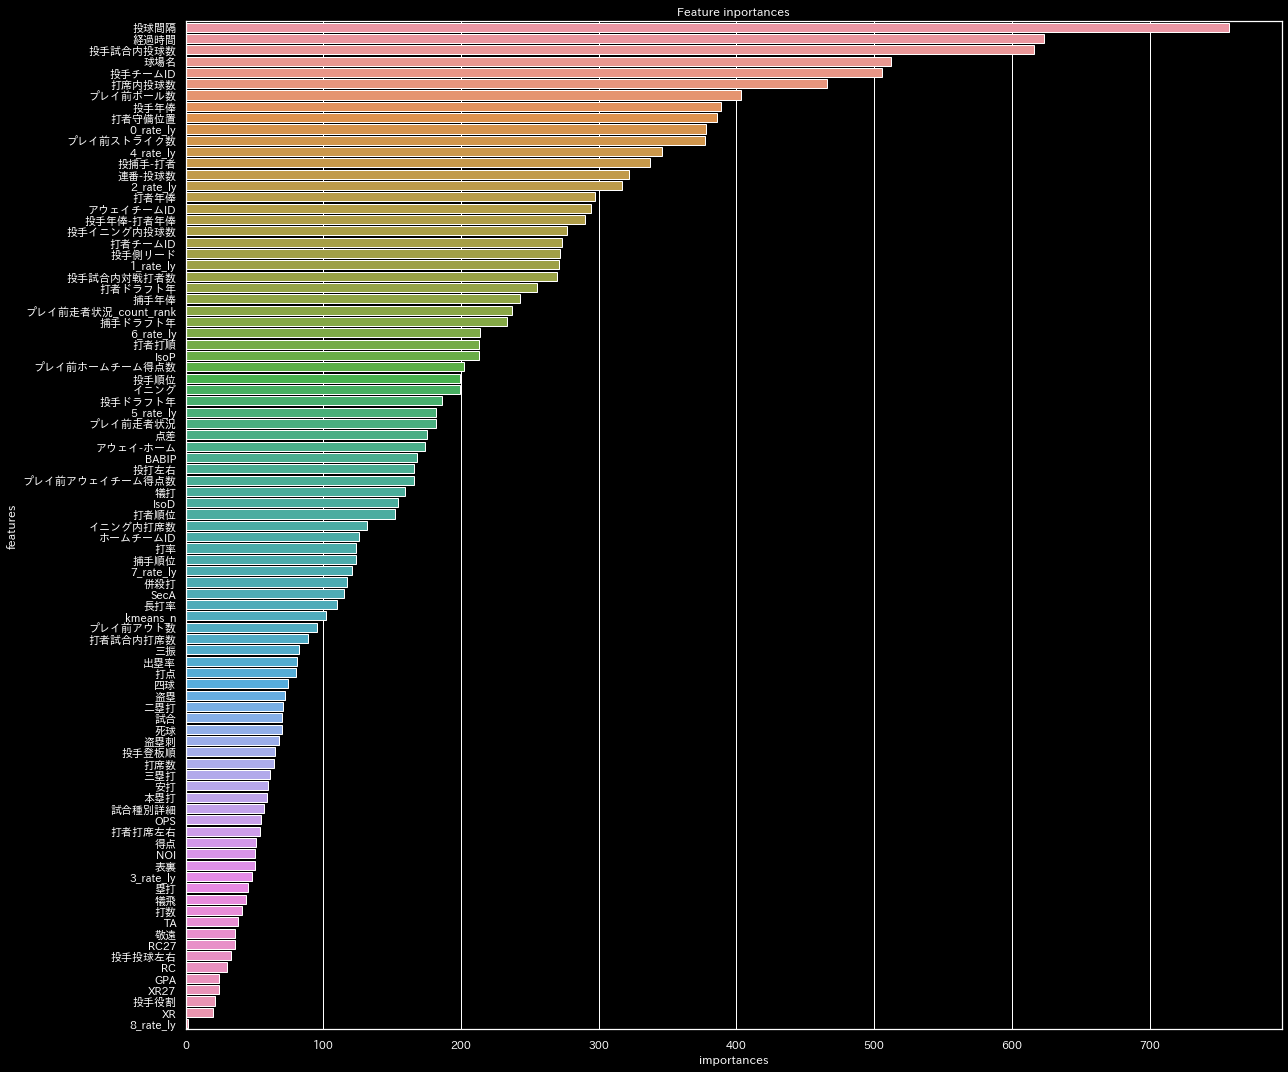

In [25]:
feature_importance = lgbm_1st.feature_importances_

importances = pd.DataFrame({"features":train_df.columns.values, "importances" : feature_importance})

plt.style.use(['dark_background'])
plt.figure(figsize=(18, 15))
plt.title("Feature inportances")
sns.barplot(x="importances", y="features", data=importances.sort_values(by="importances", ascending=False))
plt.tight_layout()

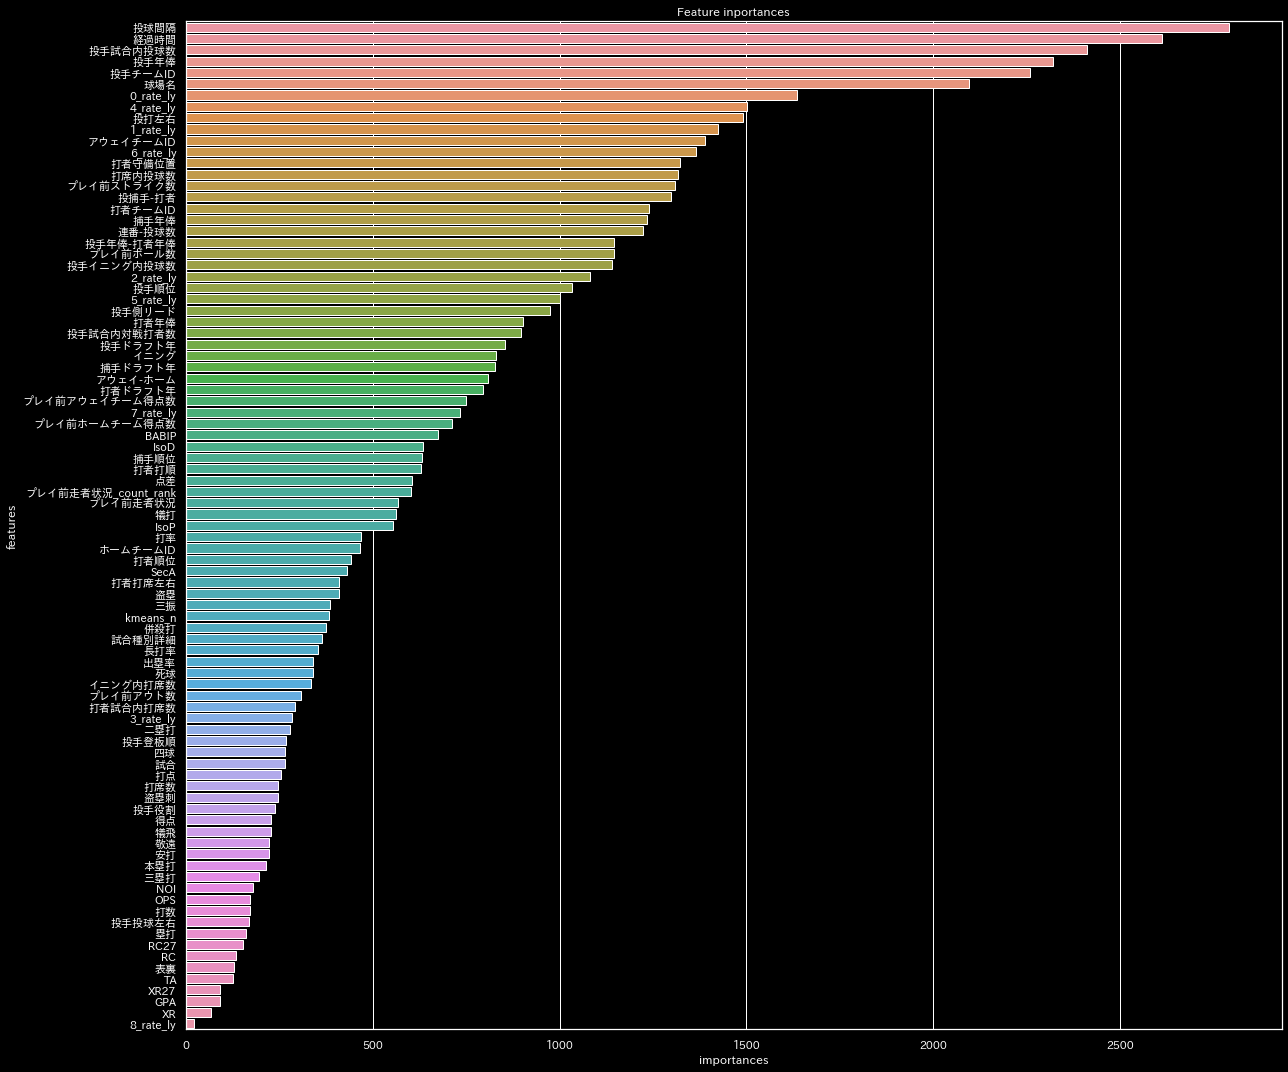

In [26]:
feature_importance = lgbm_2nd.feature_importances_

importances = pd.DataFrame({"features":train_df.columns.values, "importances" : feature_importance})

plt.style.use(['dark_background'])
plt.figure(figsize=(18, 15))
plt.title("Feature inportances")
sns.barplot(x="importances", y="features", data=importances.sort_values(by="importances", ascending=False))
plt.tight_layout()

In [27]:
lgbm_1st.fit(x,y)
lgbm_2nd.fit(x_2nd, y_2nd)

LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.88, importance_type='split',
               learning_rate=0.16, max_bin=255, max_depth=8,
               min_child_samples=20, min_child_weight=0.001,
               min_split_gain=1.2463400073939995e-05, n_estimators=100,
               n_jobs=-1, num_leaves=108, objective=None, random_state=0,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0)

In [28]:
# lgbm単体のsubmit
prediction = lgbm_1st.predict_proba(test_df)
submit_df = pd.DataFrame(data=prediction)
submit_df = submit_df.rename(columns={0: '0_', 1: '1_'})
submit_df_2nd = pd.DataFrame(data=lgbm_2nd.predict_proba(test_df))
submit_df_2nd['total'] = submit_df['1_']
for i in range(7):
    submit_df_2nd[i] = submit_df_2nd[i]*submit_df_2nd['total']

submit_df_2nd['new_total'] = submit_df_2nd.drop(columns=['total']).sum(axis=1)

lgbm_predict = pd.concat([submit_df, submit_df_2nd], axis=1).drop(columns=['1_', 'total', 'new_total'])

final_predict = lgbm_predict
final_predict.to_csv('drive/My Drive/signate/submit_lgbm_only_add_bat_perf_data.csv', header=False, index=True)

# CatBoost

In [20]:
def objective(trial):
    
    lr = trial.suggest_discrete_uniform('lr', 0.01, 1.0, 0.01)
    l2 = trial.suggest_loguniform('l2', 1e-7, 100)
    temp = trial.suggest_int('temp', 1, 5)
    #subsample = trial.suggest_discrete_uniform('subsample', 0.6, 0.95, 0.05)
    max_depth = trial.suggest_int('max_depth', 5, 10)
            
    model = CatBoostClassifier(
        n_estimators = 100,
        #bootstrap_type = 'Po'
        learning_rate = lr,
        l2_leaf_reg = l2,
        bagging_temperature = temp,
        #subsample = subsample,
        max_depth = max_depth,
        cat_features=cat_list, 
        task_type='GPU',
        random_state=0)
    
    score = cross_val_score(model, x_train, y_train, cv=3, scoring='neg_log_loss', n_jobs=-1).mean()
    score = score*-1

    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=50)

[I 2020-07-08 11:21:05,362] Finished trial#0 with value: 0.66744662349517 with parameters: {'lr': 0.55, 'l2': 0.2733406969031055, 'temp': 4, 'max_depth': 8}. Best is trial#0 with value: 0.66744662349517.
[I 2020-07-08 11:21:34,093] Finished trial#1 with value: 0.7549794430355776 with parameters: {'lr': 0.55, 'l2': 0.0006499698237449663, 'temp': 3, 'max_depth': 9}. Best is trial#0 with value: 0.66744662349517.
[I 2020-07-08 11:21:51,978] Finished trial#2 with value: 0.6542367868734865 with parameters: {'lr': 0.3, 'l2': 3.2390436139627253e-07, 'temp': 5, 'max_depth': 7}. Best is trial#2 with value: 0.6542367868734865.
[I 2020-07-08 11:22:09,043] Finished trial#3 with value: 0.6333045118097952 with parameters: {'lr': 0.48000000000000004, 'l2': 2.03947581194994, 'temp': 1, 'max_depth': 6}. Best is trial#3 with value: 0.6333045118097952.
[I 2020-07-08 11:22:37,913] Finished trial#4 with value: 0.956460599708894 with parameters: {'lr': 0.93, 'l2': 4.358374287741265e-07, 'temp': 2, 'max_depth

In [ ]:
1st
Finished trial#47 with value: 0.6323534230160175 with parameters: {'lr': 0.4, 'l2': 0.8378461318560835, 'temp': 1, 'max_depth': 6}.

2nd
Finished trial#42 with value: 1.0219954422347681 with parameters: {'lr': 0.35000000000000003, 'l2': 2.7475595407447626, 'temp': 1, 'max_depth': 9}.

In [19]:
catb_1st = CatBoostClassifier(
    n_estimators = 100,
    learning_rate = 0.40,
    l2_leaf_reg = 0.8378461318560835,
    bagging_temperature = 1,
    max_depth = 6,
    cat_features=cat_list, 
    task_type='GPU',
    random_state=0,
    verbose=100
    )

catb_1st.fit(x_train, y_train)

print(log_loss(y_train, catb_1st.predict_proba(x_train)))
print(log_loss(y_test, catb_1st.predict_proba(x_test)))


catb_2nd = CatBoostClassifier(
    n_estimators = 100,
    learning_rate = 0.35,
    l2_leaf_reg = 2.7475595407447626,
    bagging_temperature = 1,
    max_depth = 9,
    cat_features=cat_list, 
    task_type='GPU',
    random_state=0,
    verbose=100
    )

catb_2nd.fit(x_train_2nd, y_train_2nd)

print(log_loss(y_train_2nd, catb_2nd.predict_proba(x_train_2nd)))
print(log_loss(y_test_2nd, catb_2nd.predict_proba(x_test_2nd)))

prediction = catb_1st.predict_proba(x_test)
submit_df = pd.DataFrame(data=prediction)
submit_df = submit_df.rename(columns={0: '0_', 1: '1_'})
submit_df_2nd = pd.DataFrame(data=catb_2nd.predict_proba(x_test))
submit_df_2nd['total'] = submit_df['1_']
for i in range(7):
    submit_df_2nd[i] = submit_df_2nd[i]*submit_df_2nd['total']

submit_df_2nd['new_total'] = submit_df_2nd.drop(columns=['total']).sum(axis=1)
print(log_loss(y_test_org, pd.concat([submit_df, submit_df_2nd], axis=1).drop(columns=['1_', 'total', 'new_total'])))

catb_predict = pd.concat([submit_df, submit_df_2nd], axis=1).drop(columns=['1_', 'total', 'new_total'])

0:	learn: 0.6829469	total: 27.1ms	remaining: 2.68s
99:	learn: 0.6106039	total: 1.89s	remaining: 0us
0.6115528124952819
0.6280614996463698
0:	learn: 1.7943058	total: 91.1ms	remaining: 9.02s
99:	learn: 0.7836384	total: 5.39s	remaining: 0us
0.8006145064310172
0.9971282809225122
1.0854942055901835


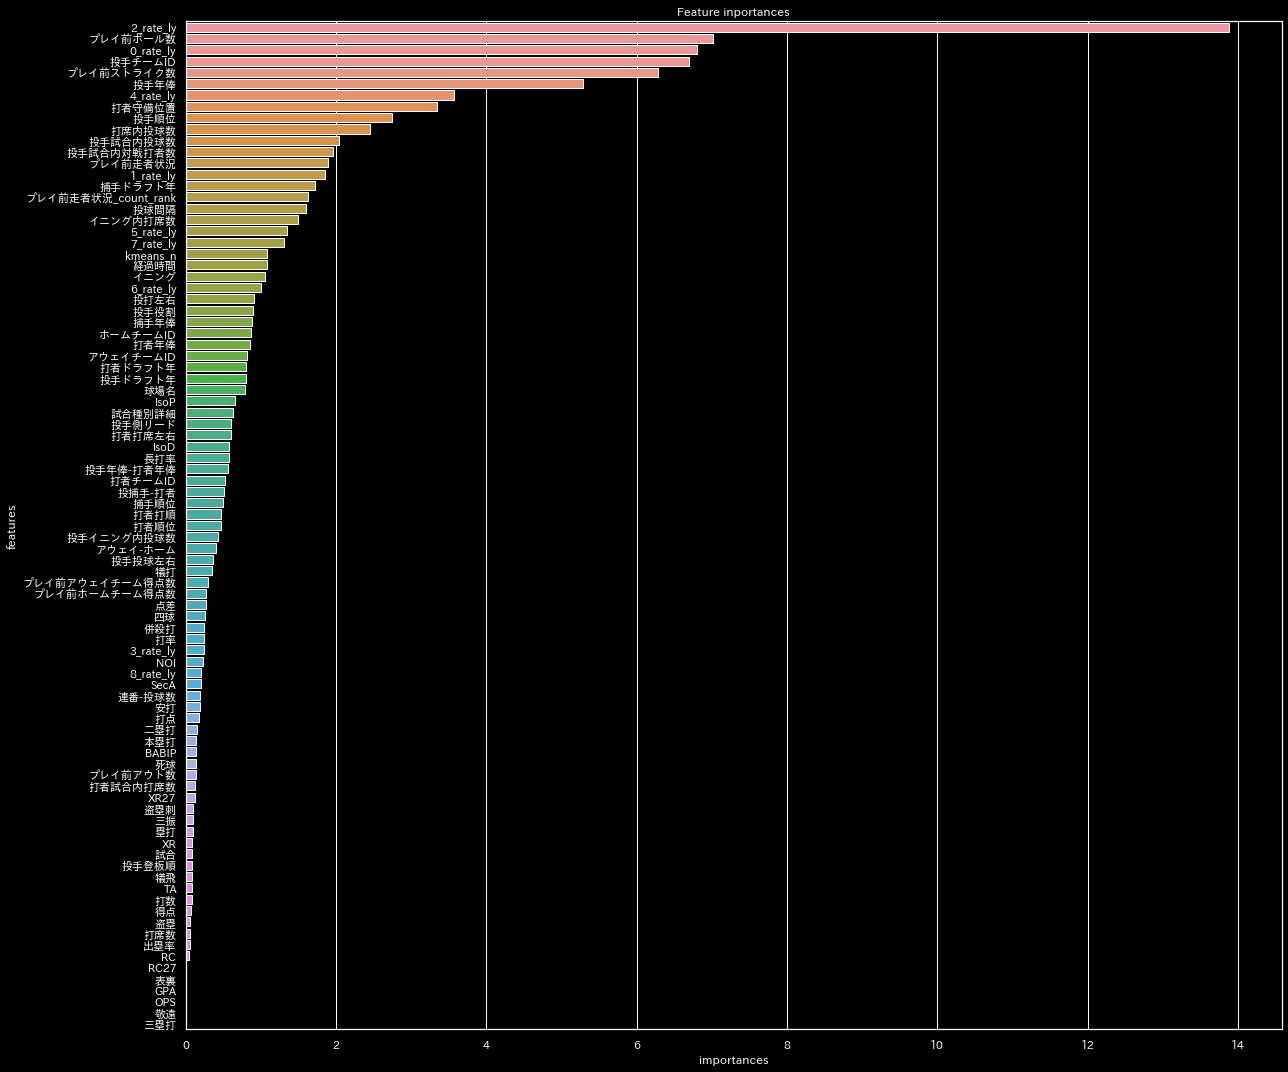

In [24]:
feature_importance = catb_1st.feature_importances_

importances = pd.DataFrame({"features":train_df.columns.values, "importances" : feature_importance})

plt.style.use(['dark_background'])
plt.figure(figsize=(18, 15))
plt.title("Feature inportances")
sns.barplot(x="importances", y="features", data=importances.sort_values(by="importances", ascending=False))
plt.tight_layout()

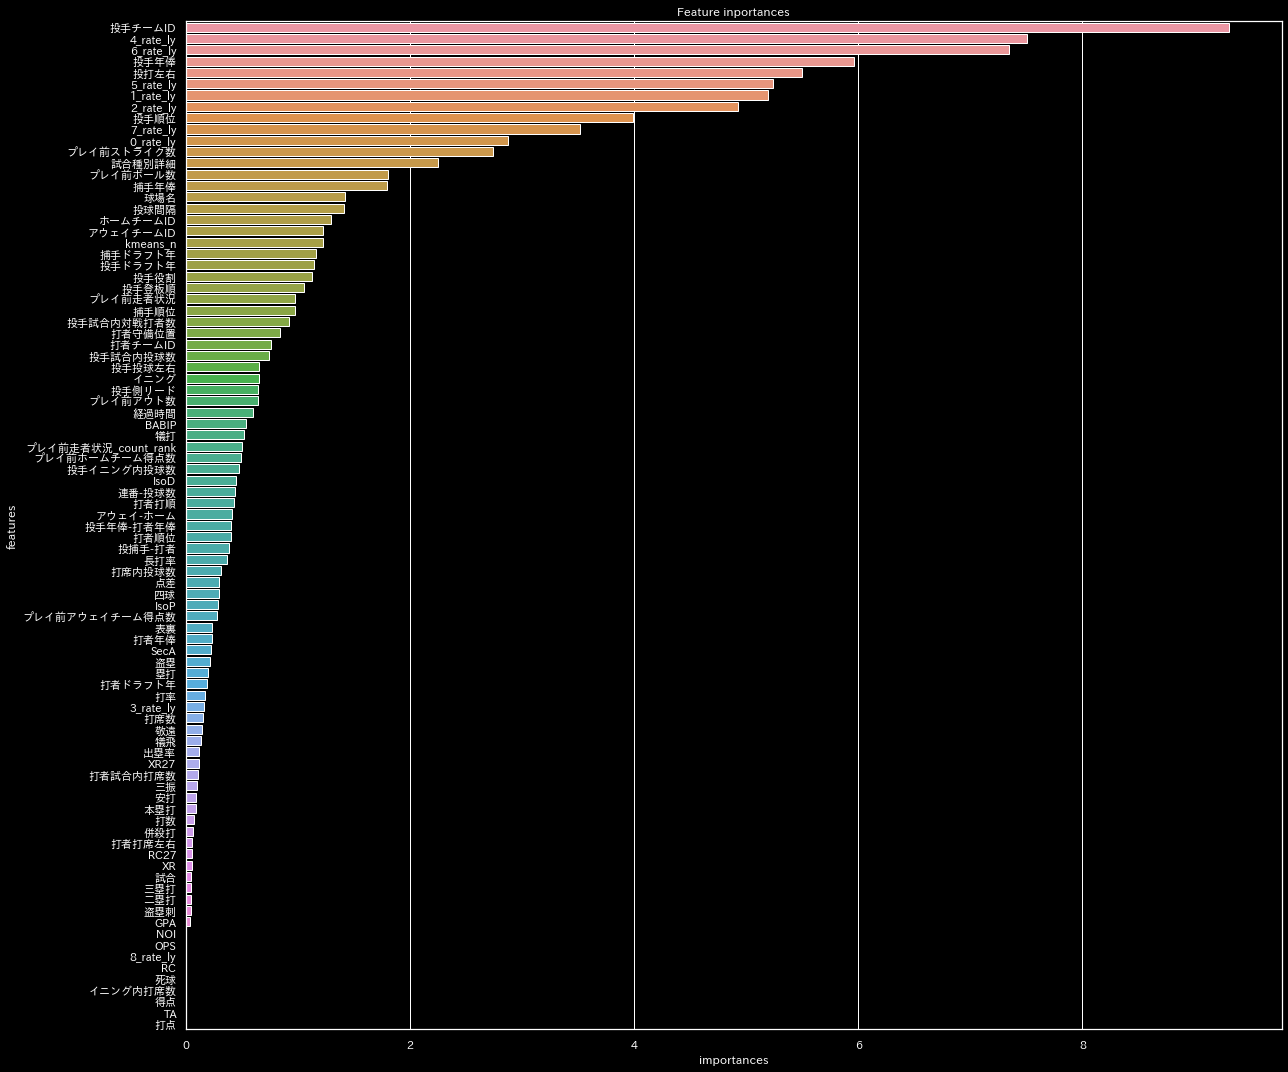

In [25]:
feature_importance = catb_2nd.feature_importances_

importances = pd.DataFrame({"features":train_df.columns.values, "importances" : feature_importance})

plt.style.use(['dark_background'])
plt.figure(figsize=(18, 15))
plt.title("Feature inportances")
sns.barplot(x="importances", y="features", data=importances.sort_values(by="importances", ascending=False))
plt.tight_layout()

In [26]:
log_loss(y_test_org, catb_predict)

1.0854942055901835

In [28]:
log_loss(y_test_org, (lgbm_predict + catb_predict)/2)

1.0540579293454813

In [29]:
# catb単体のsubmit
catb_1st.fit(x,y)
catb_2nd.fit(x_2nd, y_2nd)

prediction = catb_1st.predict_proba(test_df)
submit_df = pd.DataFrame(data=prediction)
submit_df = submit_df.rename(columns={0: '0_', 1: '1_'})
submit_df_2nd = pd.DataFrame(data=catb_2nd.predict_proba(test_df))
submit_df_2nd['total'] = submit_df['1_']
for i in range(7):
    submit_df_2nd[i] = submit_df_2nd[i]*submit_df_2nd['total']

submit_df_2nd['new_total'] = submit_df_2nd.drop(columns=['total']).sum(axis=1)

catb_predict = pd.concat([submit_df, submit_df_2nd], axis=1).drop(columns=['1_', 'total', 'new_total'])

final_predict = catb_predict
final_predict.to_csv('drive/My Drive/signate/submit_catb_only_add_bat_perf_data.csv', header=False, index=True)

0:	learn: 0.6829556	total: 29.1ms	remaining: 2.88s
99:	learn: 0.6139770	total: 2.1s	remaining: 0us
0:	learn: 1.7958470	total: 51.3ms	remaining: 5.08s
99:	learn: 0.8160183	total: 5.59s	remaining: 0us


In [30]:
lgbm_1st.fit(x,y)
lgbm_2nd.fit(x_2nd, y_2nd)

# catb_1st.fit(x,y)
# catb_2nd.fit(x_2nd, y_2nd)

# pickle.dump(lgbm_1st, open(lgbm_1st_200704, 'wb'))
# pickle.dump(lgbm_2nd, open(lgbm_2nd_200704, 'wb'))

LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.88, importance_type='split',
               learning_rate=0.16, max_bin=255, max_depth=8,
               min_child_samples=20, min_child_weight=0.001,
               min_split_gain=1.2463400073939995e-05, n_estimators=100,
               n_jobs=-1, num_leaves=108, objective=None, random_state=0,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0)

In [31]:
prediction = lgbm_1st.predict_proba(test_df)
submit_df = pd.DataFrame(data=prediction)
submit_df = submit_df.rename(columns={0: '0_', 1: '1_'})
submit_df_2nd = pd.DataFrame(data=lgbm_2nd.predict_proba(test_df))
submit_df_2nd['total'] = submit_df['1_']
for i in range(7):
    submit_df_2nd[i] = submit_df_2nd[i]*submit_df_2nd['total']

submit_df_2nd['new_total'] = submit_df_2nd.drop(columns=['total']).sum(axis=1)

lgbm_predict = pd.concat([submit_df, submit_df_2nd], axis=1).drop(columns=['1_', 'total', 'new_total'])

prediction = catb_1st.predict_proba(test_df)
submit_df = pd.DataFrame(data=prediction)
submit_df = submit_df.rename(columns={0: '0_', 1: '1_'})
submit_df_2nd = pd.DataFrame(data=catb_2nd.predict_proba(test_df))
submit_df_2nd['total'] = submit_df['1_']
for i in range(7):
    submit_df_2nd[i] = submit_df_2nd[i]*submit_df_2nd['total']

submit_df_2nd['new_total'] = submit_df_2nd.drop(columns=['total']).sum(axis=1)

catb_predict = pd.concat([submit_df, submit_df_2nd], axis=1).drop(columns=['1_', 'total', 'new_total'])

In [32]:
final_predict = (lgbm_predict + catb_predict)/2
final_predict.to_csv('drive/My Drive/signate/submit_average_bat_perf.csv', header=False, index=True)

In [ ]:
prediction = catb_1st.predict_proba(test_df)
submit_df = pd.DataFrame(data=prediction)
submit_df = submit_df.rename(columns={0: '0_', 1: '1_'})
submit_df_2nd = pd.DataFrame(data=lgbm_2nd.predict_proba(test_df))
submit_df_2nd['total'] = submit_df['1_']
for i in range(7):
    submit_df_2nd[i] = submit_df_2nd[i]*submit_df_2nd['total']

submit_df_2nd['new_total'] = submit_df_2nd.drop(columns=['total']).sum(axis=1)
pd.concat([submit_df, submit_df_2nd], axis=1).drop(columns=['1_', 'total', 'new_total']).to_csv('drive/My Drive/signate/submit_catb_1st_lgbm_2nd.csv', header=False, index=True)